In [2]:
# Step a: Import required libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load the data (adjust the path to your March 2020 file)
nycgreen = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/green_tripdata_2020-03.parquet")

# Display basic info
nycgreen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223496 entries, 0 to 223495
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               223496 non-null  int64         
 1   lpep_pickup_datetime   223496 non-null  datetime64[us]
 2   lpep_dropoff_datetime  223496 non-null  datetime64[us]
 3   store_and_fwd_flag     176287 non-null  object        
 4   RatecodeID             176287 non-null  float64       
 5   PULocationID           223496 non-null  int64         
 6   DOLocationID           223496 non-null  int64         
 7   passenger_count        176287 non-null  float64       
 8   trip_distance          223496 non-null  float64       
 9   fare_amount            223496 non-null  float64       
 10  extra                  223496 non-null  float64       
 11  mta_tax                223496 non-null  float64       
 12  tip_amount             223496 non-null  floa

In [3]:
# Drop ehail_fee column (all nulls) and fare_amount as requested
nycgreen = nycgreen.drop(["ehail_fee", "fare_amount"], axis=1)

In [4]:
# Calculate trip duration in minutes
nycgreen["trip_duration"] = (nycgreen["lpep_dropoff_datetime"] - nycgreen["lpep_pickup_datetime"]).dt.total_seconds() / 60

In [5]:
# Extract weekday from dropoff datetime
nycgreen["weekday"] = nycgreen["lpep_dropoff_datetime"].dt.day_name()

# Value counts of weekday
print(nycgreen["weekday"].value_counts(dropna=False))

weekday
Monday       35566
Tuesday      34967
Wednesday    33211
Thursday     32995
Friday       32066
Sunday       29862
Saturday     24829
Name: count, dtype: int64


In [6]:
# Extract hour from dropoff datetime
nycgreen["hourofday"] = nycgreen["lpep_dropoff_datetime"].dt.hour

# Value counts of hour
print(nycgreen["hourofday"].value_counts(dropna=False))

hourofday
17    15915
18    15607
16    15043
15    14242
19    13261
14    13243
10    13118
9     13102
13    12583
11    12571
12    12561
20    11197
8     11067
21     9057
22     7721
7      7308
23     6339
0      4976
6      3438
1      3189
4      2099
5      1999
2      1956
3      1904
Name: count, dtype: int64


In [7]:
# Check for missing values
print(nycgreen.isnull().sum())

# Impute missing values
# For numerical columns, use median
num_cols = ['passenger_count', 'trip_distance', 'extra', 'mta_tax',
            'tip_amount', 'tolls_amount', 'improvement_surcharge',
            'congestion_surcharge', 'trip_duration']
for col in num_cols:
    nycgreen[col] = nycgreen[col].fillna(nycgreen[col].median())

# For categorical columns, use mode
cat_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type']
for col in cat_cols:
    nycgreen[col] = nycgreen[col].fillna(nycgreen[col].mode()[0])

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag       47209
RatecodeID               47209
PULocationID                 0
DOLocationID                 0
passenger_count          47209
trip_distance                0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
payment_type             47209
trip_type                47210
congestion_surcharge     47209
trip_duration                0
weekday                      0
hourofday                    0
dtype: int64


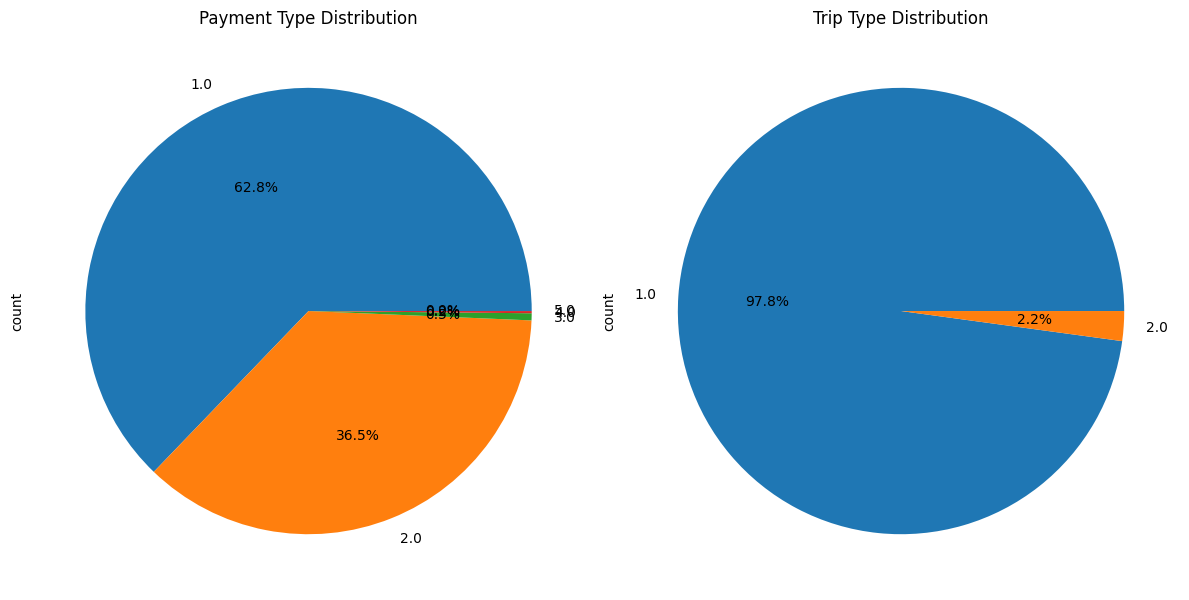

In [8]:
# Pie chart for payment_type
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
nycgreen['payment_type'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Payment Type Distribution')

# Pie chart for trip_type
plt.subplot(1, 2, 2)
nycgreen['trip_type'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Trip Type Distribution')
plt.tight_layout()
plt.show()

weekday
Saturday     15.664572
Friday       16.369651
Monday       16.806046
Tuesday      16.820616
Sunday       16.990471
Thursday     17.022256
Wednesday    17.075731
Name: total_amount, dtype: float64


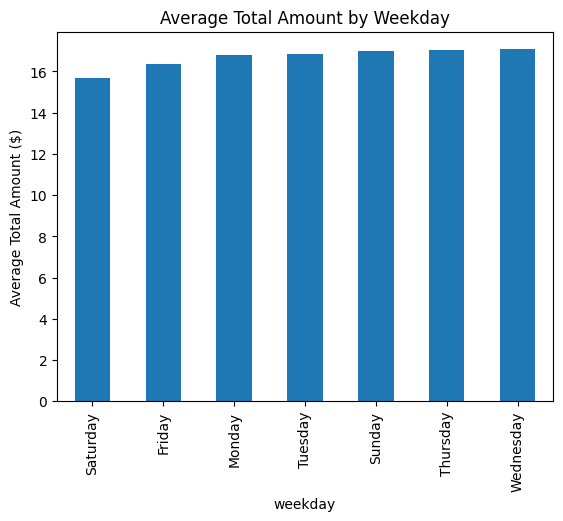

In [9]:
# Average total_amount by weekday
weekday_avg = nycgreen.groupby('weekday')['total_amount'].mean().sort_values()
print(weekday_avg)

# Plot
weekday_avg.plot(kind='bar')
plt.title('Average Total Amount by Weekday')
plt.ylabel('Average Total Amount ($)')
plt.show()

payment_type
3.0     2.042699
4.0     2.341114
5.0     9.680000
2.0    11.994025
1.0    19.616623
Name: total_amount, dtype: float64


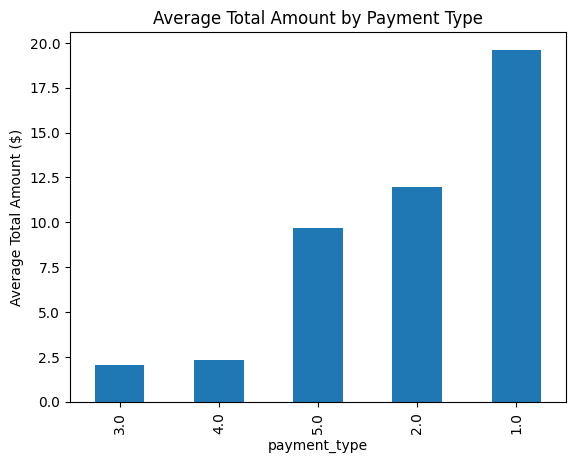

In [10]:
# Average total_amount by payment_type
payment_avg = nycgreen.groupby('payment_type')['total_amount'].mean().sort_values()
print(payment_avg)

# Plot
payment_avg.plot(kind='bar')
plt.title('Average Total Amount by Payment Type')
plt.ylabel('Average Total Amount ($)')
plt.show()

weekday
Monday       0.854771
Tuesday      0.868493
Wednesday    0.892593
Friday       0.917329
Saturday     0.919418
Thursday     0.942061
Sunday       0.959795
Name: tip_amount, dtype: float64


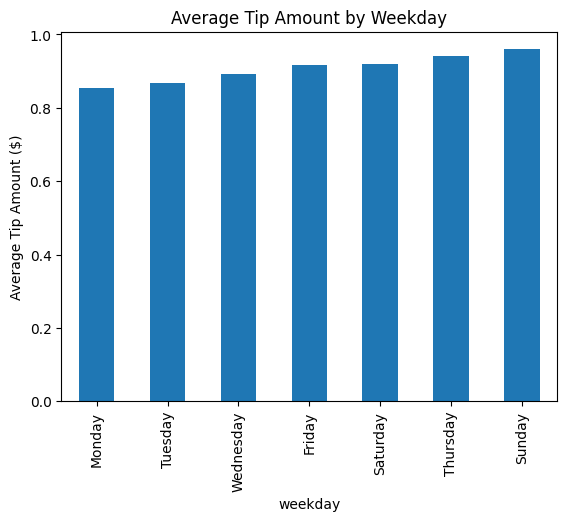

In [11]:
# Average tip_amount by weekday
weekday_tip_avg = nycgreen.groupby('weekday')['tip_amount'].mean().sort_values()
print(weekday_tip_avg)

# Plot
weekday_tip_avg.plot(kind='bar')
plt.title('Average Tip Amount by Weekday')
plt.ylabel('Average Tip Amount ($)')
plt.show()

payment_type
3.0   -0.016670
4.0   -0.004543
5.0    0.000000
2.0    0.000038
1.0    1.442037
Name: tip_amount, dtype: float64


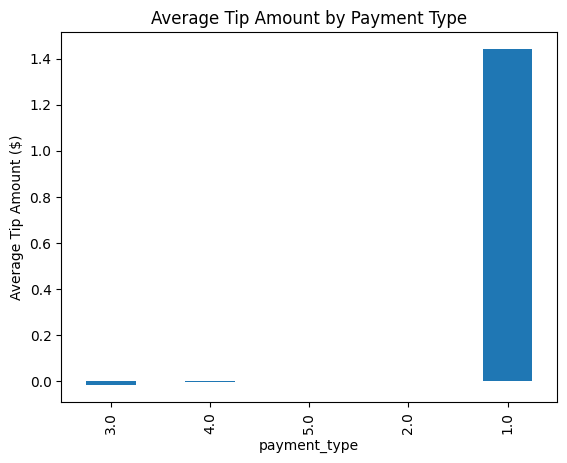

In [12]:
# Average tip_amount by payment_type
payment_tip_avg = nycgreen.groupby('payment_type')['tip_amount'].mean().sort_values()
print(payment_tip_avg)

# Plot
payment_tip_avg.plot(kind='bar')
plt.title('Average Tip Amount by Payment Type')
plt.ylabel('Average Tip Amount ($)')
plt.show()

In [13]:
# ANOVA test for trip_type and total_amount
model = ols('total_amount ~ C(trip_type)', data=nycgreen).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                    sum_sq        df           F        PR(>F)
C(trip_type)  2.986100e+04       1.0  172.496239  2.180722e-39
Residual      3.868927e+07  223494.0         NaN           NaN


In [14]:
# ANOVA test for weekday and total_amount
model = ols('total_amount ~ C(weekday)', data=nycgreen).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq        df          F        PR(>F)
C(weekday)  4.160810e+04       6.0  40.070437  4.854185e-49
Residual    3.867753e+07  223489.0        NaN           NaN


In [15]:
# Chi-square test of independence
contingency_table = pd.crosstab(nycgreen['trip_type'], nycgreen['payment_type'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 1067.7836933865894
P-value: 7.277513604894759e-230


In [16]:
# Numeric variables (already defined in step f)
# Object variables
obj_cols = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday', 'hourofday']

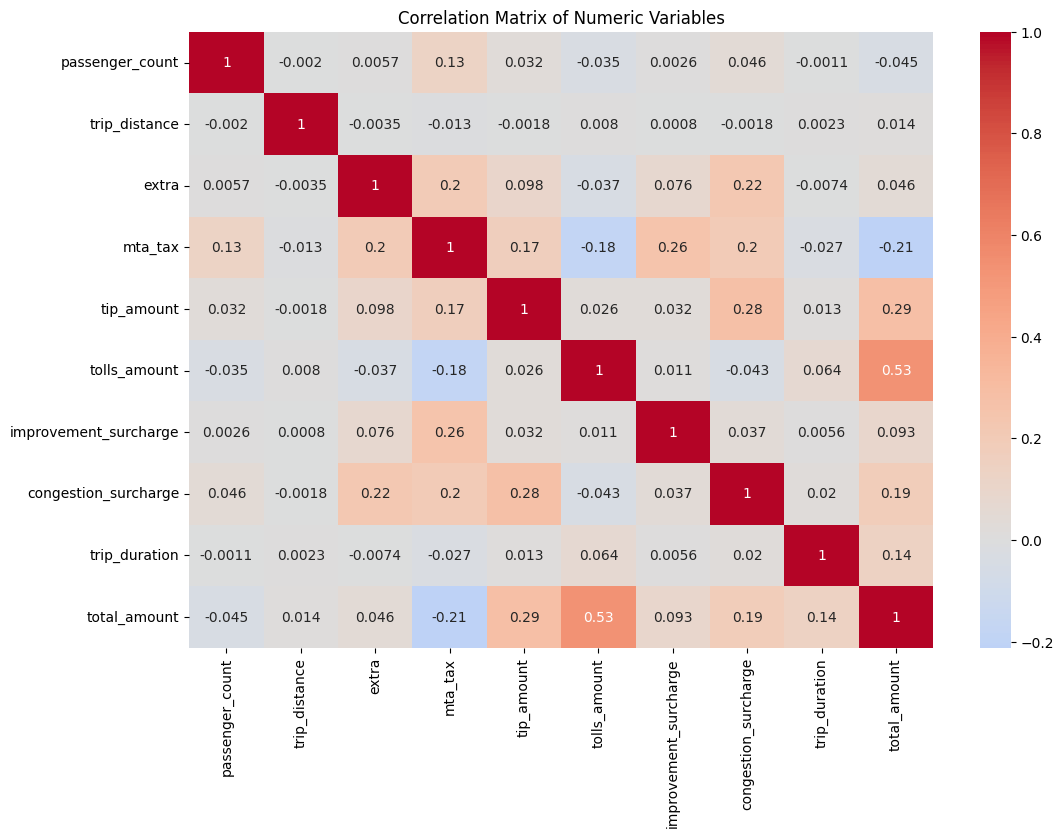

In [17]:
# Correlation matrix
corr_matrix = nycgreen[num_cols + ['total_amount']].corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

In [18]:
# Dummy encoding for categorical variables
nycgreen_encoded = pd.get_dummies(nycgreen, columns=obj_cols, drop_first=True)

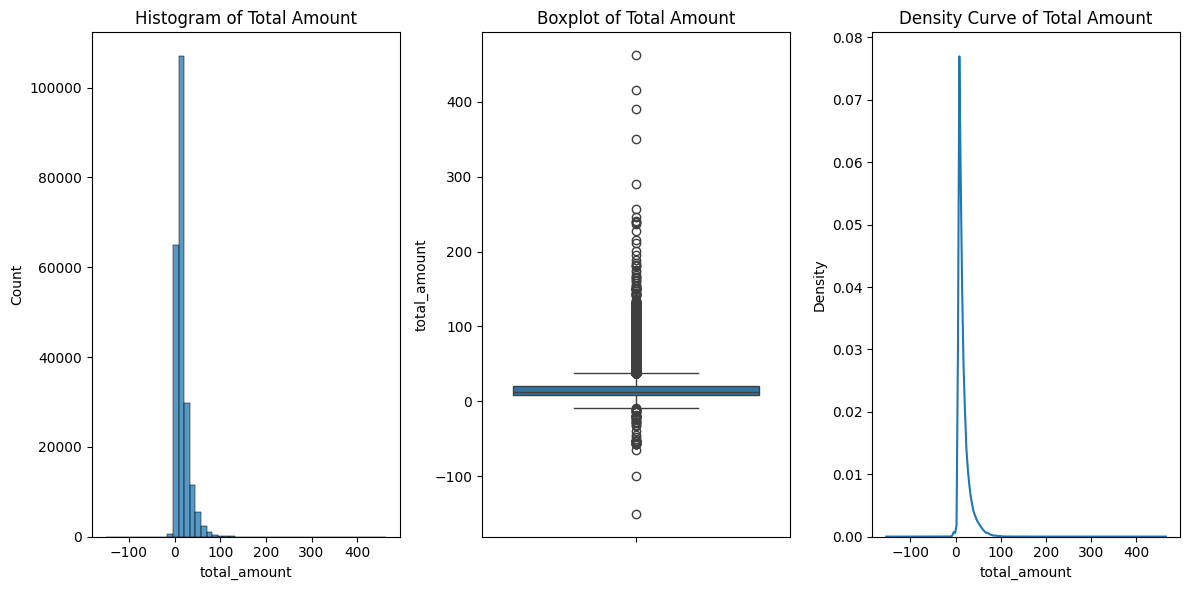

In [19]:
# Histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.histplot(nycgreen['total_amount'], bins=50, kde=False)
plt.title('Histogram of Total Amount')

# Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=nycgreen['total_amount'])
plt.title('Boxplot of Total Amount')

# Density curve
plt.subplot(1, 3, 3)
sns.kdeplot(nycgreen['total_amount'])
plt.title('Density Curve of Total Amount')
plt.tight_layout()
plt.show()

In [20]:
# Prepare X and y
X = nycgreen_encoded.drop(['total_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
                          'VendorID', 'PULocationID', 'DOLocationID'], axis=1)
y = nycgreen_encoded['total_amount']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)

# Evaluation
print("Linear Regression:")
print(f"MSE: {mean_squared_error(y_test, y_pred_lr)}")
print(f"R-squared: {r2_score(y_test, y_pred_lr)}")

Linear Regression:
MSE: 96.41187743754347
R-squared: 0.4516362075142697


In [22]:
# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)

# Evaluation
print("\nDecision Tree:")
print(f"MSE: {mean_squared_error(y_test, y_pred_dt)}")
print(f"R-squared: {r2_score(y_test, y_pred_dt)}")


Decision Tree:
MSE: 28.16913888814318
R-squared: 0.8397818169056387


In [23]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
print("\nRandom Forest:")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"R-squared: {r2_score(y_test, y_pred_rf)}")


Random Forest:
MSE: 17.420244255083333
R-squared: 0.9009185231152299


In [24]:
# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Predictions
y_pred_gb = gb.predict(X_test)

# Evaluation
print("\nGradient Boosting:")
print(f"MSE: {mean_squared_error(y_test, y_pred_gb)}")
print(f"R-squared: {r2_score(y_test, y_pred_gb)}")


Gradient Boosting:
MSE: 18.144994185834534
R-squared: 0.896796348221499


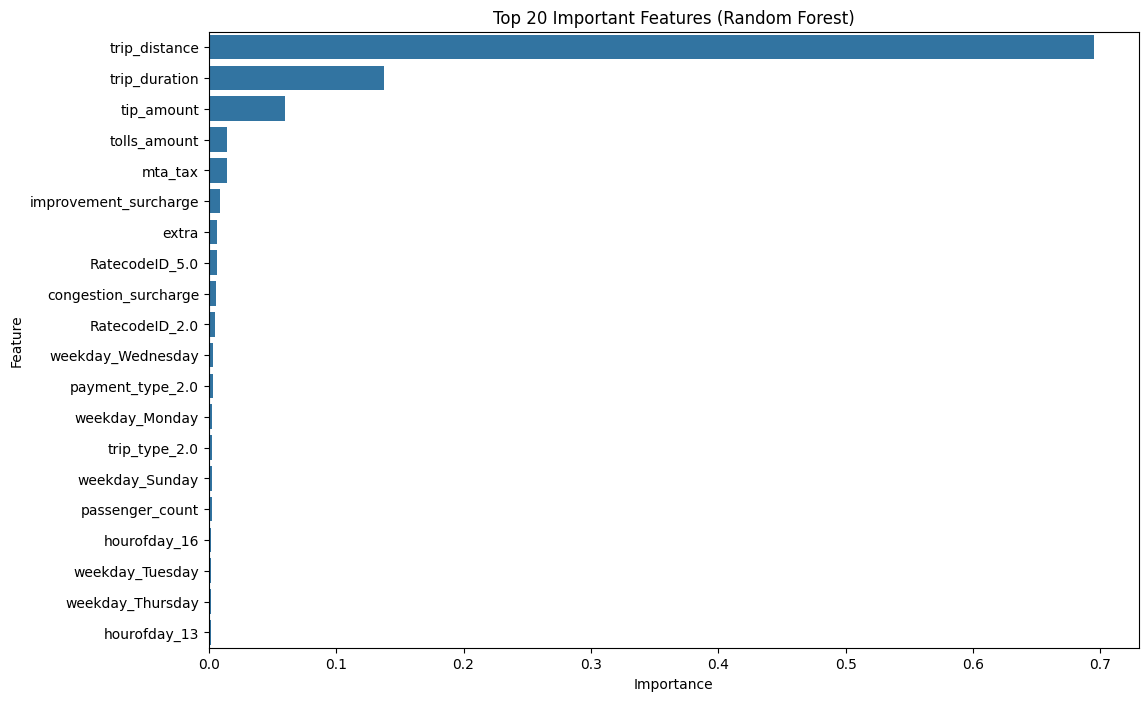

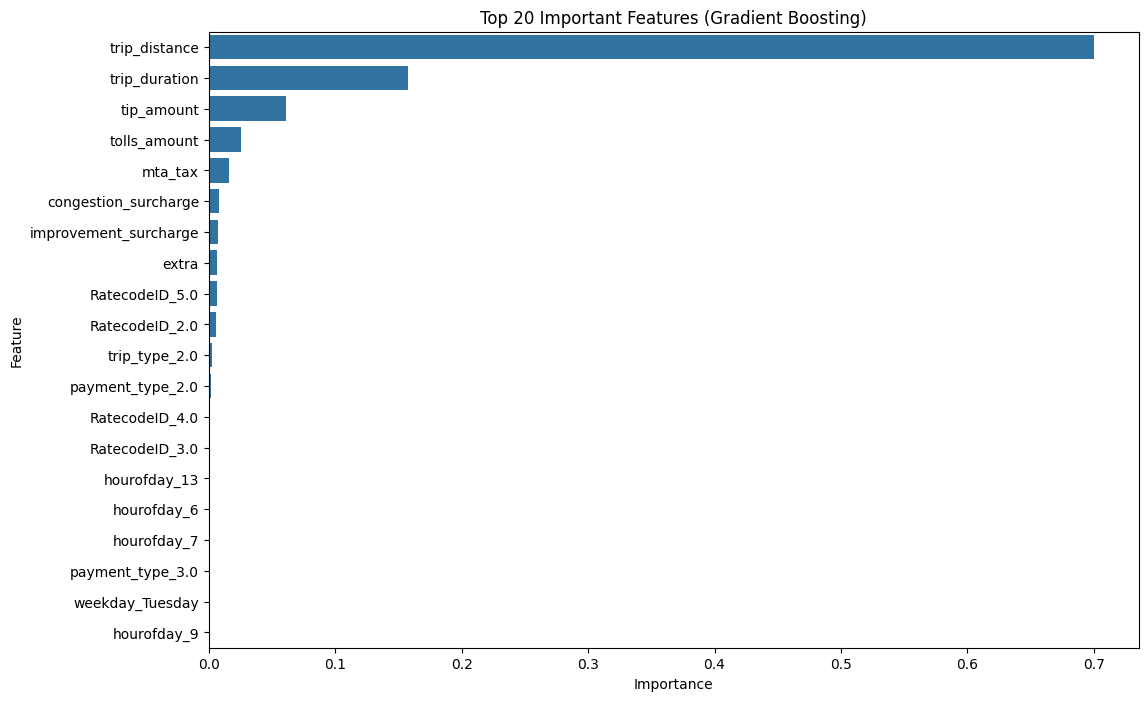

In [25]:
# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Important Features (Random Forest)')
plt.show()

# Feature importance for Gradient Boosting
feature_importance_gb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_gb.head(20))
plt.title('Top 20 Important Features (Gradient Boosting)')
plt.show()